In [7]:
from src.config import BLD
from src.config import SRC
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

""" from src.utils import remove_brackets_in_categorical_values
from src.data_management.cleaning_helpers.renaming_replacing import set_types_file
from src.data_management.cleaning_helpers.data_checks import general_data_checks """

' from src.utils import remove_brackets_in_categorical_values\nfrom src.data_management.cleaning_helpers.renaming_replacing import set_types_file\nfrom src.data_management.cleaning_helpers.data_checks import general_data_checks '

In [2]:
df_h=pd.read_stata("src/original_data/HHENDDAT_cf_W11.dta",convert_categoricals=False)

In [3]:
df_p=pd.read_stata("src/original_data/PENDDAT_cf_W11.dta",convert_categoricals=False)

In [2]:
df_h_c = pd.read_pickle(BLD/"HHENDDAT_clean.pickle")


In [3]:
df_p_c = pd.read_pickle(BLD/"PENDDAT_clean.pickle")


In [11]:
x = df_p_c.groupby("wave").count()["p_id"].reset_index()["wave"]
y = df_p_c.groupby("wave").count()["p_id"].reset_index()["p_id"]

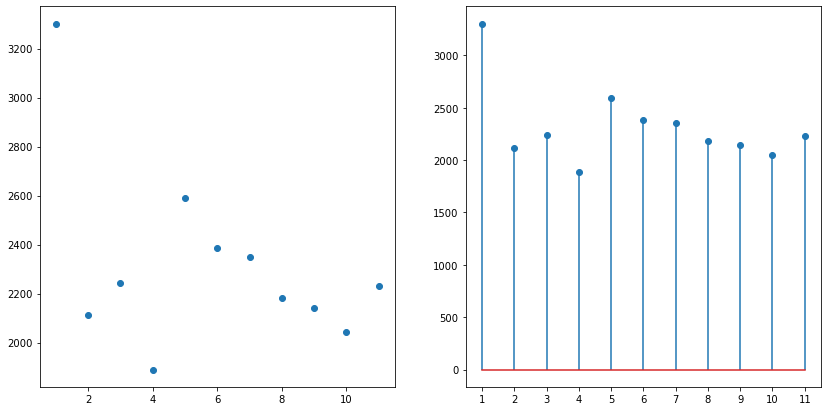

In [30]:
# number of observation per wave
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,7))
ax1.scatter(x,y)
ax2.stem(x,y)
plt.xticks(x)
plt.show()

In [103]:
df_p_c.iloc[df_p_c.index.get_level_values('wave') == 11].groupby("age").count()["p_id"].reset_index()["age"]

0     15.0
1     16.0
2     17.0
3     18.0
4     19.0
      ... 
73    88.0
74    89.0
75    90.0
76    91.0
77    94.0
Name: age, Length: 78, dtype: float64

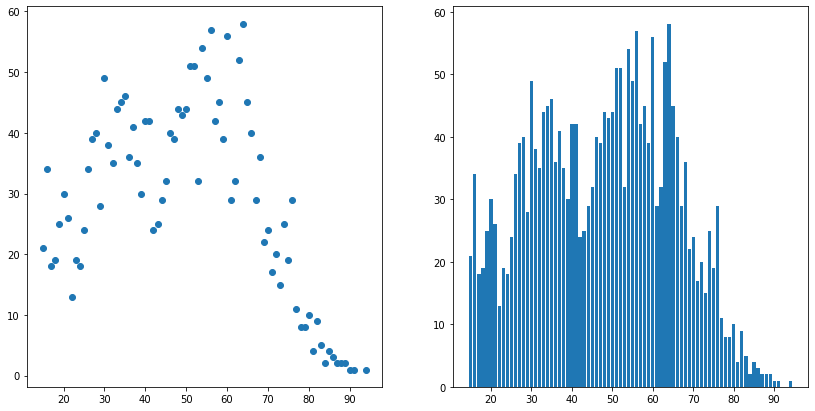

In [125]:
# number of observation per age
x=df_p_c.iloc[df_p_c.index.get_level_values('wave') == 11].groupby("age").count()["p_id"].reset_index()["age"]
y=df_p_c.iloc[df_p_c.index.get_level_values('wave') == 11].groupby("age").count()["p_id"].reset_index()["p_id"]
#x=df_p_c.groupby("age").count()["p_id"].reset_index()["age"]
#y=df_p_c.groupby("age").count()["p_id"].reset_index()["p_id"]
#.count()["p_id"].reset_index()["wave"]
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,7))
ax1.scatter(x,y)
ax2.bar(x,y)
#plt.xticks(x)
plt.savefig(BLD /"figure.png")
plt.show()


In [72]:
pd.Categorical(df_p_c.sex).rename_categories({1.0:"male",2.0:"female"})

AttributeError: 'Categorical' object has no attribute 'hist'

In [112]:
df_p_c.iloc[df_p_c.index.get_level_values('wave') == 11].groupby("sex").count()

,p_id,survey_year,survey_mon,age,religiosity,PA0100,PA0300,PA0800,PA0900,PA1000,...,b5_open,eri_effort,eri_reward,genrole_traditional,sex_dummy,salary_dummy,PG0100_dummy,PSM0100_dummy,PSK0100_dummy,unemp_dummy
sex,,,,,,,,,,,,,,,,,,,,,
1.0,1145,1145,1145,1145,173,1145,1144,1137,1134,1144,...,0,0,0,0,1145,934,1143,938,1144,934
2.0,1239,1239,1239,1239,146,1239,1239,1234,1230,1236,...,0,0,0,0,1239,1036,1237,991,1237,1036


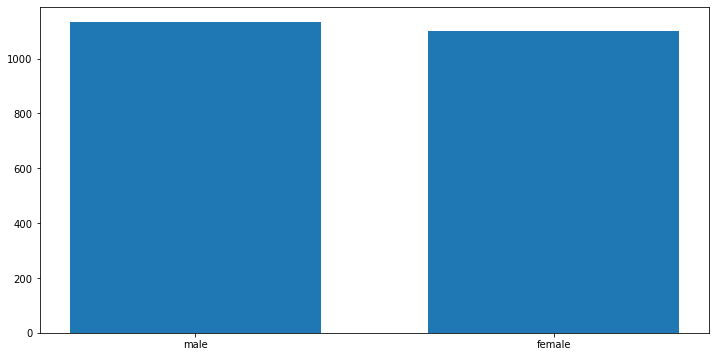

In [122]:
x=df_p_c.iloc[df_p_c.index.get_level_values('wave') == 11].groupby("sex").count()["p_id"].reset_index()["sex"]
y=df_p_c.iloc[df_p_c.index.get_level_values('wave') == 11].groupby("sex").count()["p_id"].reset_index()["p_id"]
fig, ax = plt.subplots(figsize=(12,6))
#ax.bar(pd.Categorical(df_p_c.sex).rename_categories({1.0:"male",2.0:"female"}))
ax.bar(x,y,width=0.7)
plt.xticks([1,2],["male","female"])

plt.show()

In [6]:
dummy_b=pd.get_dummies(df_h_c['HLS0900b'],prefix="HLS0900b",dummy_na=True)
dummy_b.loc[dummy_b.HLS0900b_nan==1,["HLS0900b_1.0","HLS0900b_2.0"]]=np.nan
dummy_b

HLS0900b_1.0  HLS0900b_2.0  HLS0900b_nan
hh_id       wave                                          
10000019.0  1.0            NaN           NaN             1
            3.0            NaN           NaN             1
10000020.0  1.0            NaN           NaN             1
            2.0            NaN           NaN             1
            3.0            NaN           NaN             1
...                        ...           ...           ...
110002040.0 11.0           NaN           NaN             1
110002041.0 11.0           NaN           NaN             1
110002042.0 11.0           1.0           0.0             0
110002045.0 11.0           NaN           NaN             1
110002057.0 11.0           NaN           NaN             1

[17874 rows x 3 columns]

In [123]:
if df_h_c["HLS0900b"] == 1:
    df_h_c["HLS0900b_d"] = 1
elif (df_h_c["HLS0900b"]==2 | df_h_c["HLS0900a"]==1):
    df_h_c["HLS0900b_d"] = 0
else:
    df_h_c["HLS0900b_d"] =np.nan

In [ ]:
def create_dummies_depr(dummies_h=None):
    df_h = pd.read_pickle(BLD / "HHENDDAT_clean.pickle")
    if dummies_h is None:
        dummies_h = Path(SRC / "data_management/dummies/HHENDDAT_dummies.yaml")
    with open(dummies_h) as stream:
        dummies_h = yaml.safe_load(stream)["deprivation"]
    for dummies in dummies_h:
        df_h[df_h[f"{dummies}_b"] == 1,"HLS0900_dummies"]=1
        df_h[df_h[f"{dummies}_b"] == 2 ,"HLS0900_dummies"]=0
        df_h[df_h[f"{dummies}_a"] == 1 ,"HLS0900_dummies"]=0
    return df_h


In [168]:
df_h_c.loc[df_h_c["HLS0900b"] == 1,"HLS0900b_d"]=1

In [32]:
 # df = pd.concat([df, pd.get_dummies(df['YEAR'])], axis=1)
 # It is better to include inplace=True when writing the function
sex_dummy = pd.get_dummies(df_p_c['sex'],prefix="sex",).rename(columns = {'sex_1.0': 'sex_male', 'sex_2.0': 'sex_female'})
salary_dummy=pd.get_dummies(df_p_c["salary"],prefix="salary",).rename(columns = {'salary_1.0': 'salary_emp', 'salary_2.0': 'salary_nemp'})
df_p_c['doc_dummy']=(df_p_c['PG0100'] > 0).astype(int)
social_media_dummy=pd.get_dummies(df_p_c['PSM0100'],prefix="soc_med").rename(columns = {'soc_med_1.0': 'soc_med_use', 'soc_med_2.0': 'soc_med_no_use'})
close_friend_dummy= pd.get_dummies(df_p_c['PSK0100'],prefix="close_friend").rename(columns = {'close_friend_1.0': 'close_friend', 'close_friend_2.0': 'close_friend_no'})
# HH variables
alg2_dummy=pd.get_dummies(df_h_c['hh_alg2'],prefix="hh_alg2").rename(columns = {'hh_alg2_1.0': 'hh_alg2_receiving', 'hh_alg2_2.0': 'hh_alg2_notreceiving'})
child_benefit_dummy=pd.get_dummies(df_h_c['child_benefit'],prefix="child_benefit").rename(columns = {'child_benefit_1.0': 'child_benefit_receive', 'child_benefit_2.0': 'child_benefit_notreceiving'})

In [63]:
def create_dummies(dummies_p= None, dummies_h=None):
    df_p = pd.read_pickle(BLD/"PENDDAT_clean.pickle")
    df_h = pd.read_pickle(BLD/"HHENDDAT_clean.pickle")
    if dummies_p == None:
        dummies_p=Path(SRC / "data_management/dummies/PENDDAT_dummies.yaml")
    if dummies_h == None:
        dummies_h=Path(SRC / "data_management/dummies/HHENDDAT_dummies.yaml")
    with open(dummies_p, 'r') as stream:
        dummies_p = yaml.safe_load(stream)
    with open(dummies_h, 'r') as stream:
        dummies_h = yaml.safe_load(stream)
    for dummies in dummies_p:
        if dummies == "PG0100":
            df_p[f"{dummies}_d"] = (df_p[f'{dummies}'] > 0).astype(int)    
        else:
            df_p=pd.concat([df_p,pd.get_dummies(df_p[f'{dummies}'],prefix=f"{dummies}").rename(columns = {f'{dummies}_1.0': f'{dummies}_d'}) ], axis=1).drop(f'{dummies}_2.0', axis=1)
    for dummies in dummies_h:
        df_h=pd.concat([df_h,pd.get_dummies(df_h[f'{dummies}'],prefix=f"{dummies}").rename(columns = {f'{dummies}_1.0': f'{dummies}_d'}) ], axis=1).drop(f'{dummies}_2.0', axis=1)
    return (df_p , df_h)

In [67]:
 pd.get_dummies(df_p_c['sex'],prefix="sex",).rename(columns = {'sex_1.0': 'sex_male', 'sex_2.0': 'sex_female'})

sex_male  sex_female
hh_id       wave                      
10000019.0  1.0          0           1
            1.0          1           0
            3.0          0           1
10000020.0  1.0          1           0
            1.0          0           1
...                    ...         ...
110002041.0 11.0         1           0
110002042.0 11.0         1           0
            11.0         1           0
110002045.0 11.0         1           0
110002057.0 11.0         1           0

[25474 rows x 2 columns]

In [34]:
import yaml
with open("C:\Project\EPP_project\pass_data_preparation\src\data_management\PENDDAT\PENDDAT_dummies.yaml", 'r') as stream:
    out = yaml.safe_load(stream)
out

['sex', 'salary', 'PG0100', 'PSM0100', 'PSK0100']

In [ ]:
new_names=pd.read_csv("src/data_management/PENDDAT/penddat_renaming.csv",sep=";")["new_name"]

In [ ]:
renaming_dict=dict(zip(df.columns,new_names))

In [ ]:
renaming_dict = {k: v for k, v in renaming_dict.items() if pd.notna(v)}

In [ ]:
def _renaming_columns(path):
    df=pd.read_stata(path,convert_categoricals=False)
    new_names=pd.read_csv("src/data_management/PENDDAT/penddat_renaming.csv",sep=";")["new_name"]
    renaming_dict=dict(zip(df.columns,new_names))
    renaming_dict = {k: v for k, v in renaming_dict.items() if pd.notna(v)}
    return df.rename(columns=renaming_dict)

In [ ]:
def _replacing_negative(df,negatives=list(range(-1,-11,-1))):
    for i in negatives:
        df[df==i]=np.nan
    return df


In [4]:
import os
from pathlib import Path
import glob

In [12]:
files = [file for file in glob.glob("C:\Project\EPP_project\pass_data_preparation\src\original_data\*")]

In [1]:
def get_names_dataset(path="C:\Project\EPP_project\pass_data_preparation\src\original_data"):
    a = r"\*"
    files = list(glob.glob(path + f"{a}"))
    #[file for file in glob.glob(path+f"\*")]
    name=[]
    for i in range(len(files)):
        if any(x.isupper() for x in files[i].split("\\")[-1].split("_")[0]):
            name.append(files[i].split("\\")[-1].split("_")[0])
        else:
            #a=files[i].split("\\")[6].split("_")[0:2]
            name.append(files[i].split("\\")[-1].split("_")[0]+"_"+files[i].split("\\")[-1].split("_")[1])
    return name 
    